# House Prices - Decision Trees and Random Forests

![](https://i.imgur.com/3sw1fY9.jpg)

In this project, I will predict the price of a house using information like its location, area, no. of rooms etc. The dataset can be downloaded from the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition on [Kaggle](https://kaggle.com). 

We'll follow a step-by-step process:

1. Download and prepare the dataset for training
2. Train, evaluate and interpret a decision tree
3. Train, evaluate and interpret a random forest
4. Tune hyperparameters to improve the model
5. Make predictions




Let's begin by installing the required libraries.

In [1]:
!pip install opendatasets scikit-learn plotly folium --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 KB 4.9 MB/s eta 0:00:00


In [2]:
!pip install pandas numpy matplotlib seaborn --quiet

## Download and prepare the dataset for training

In [3]:
import os
from zipfile import ZipFile
from urllib.request import urlretrieve

dataset_url = 'https://github.com/JovianML/opendatasets/raw/master/data/house-prices-advanced-regression-techniques.zip'
urlretrieve(dataset_url, 'house-prices.zip')
with ZipFile('house-prices.zip') as f:
    f.extractall(path='house-prices')
    
os.listdir('house-prices')

['train.csv', 'data_description.txt', 'test.csv', 'sample_submission.csv']

In [4]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

prices_df = pd.read_csv('house-prices/train.csv')
prices_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [5]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify input and target columns
input_cols, target_col = prices_df.columns[1:-1], prices_df.columns[-1]
inputs_df, targets = prices_df[input_cols].copy(), prices_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = prices_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = prices_df[input_cols].select_dtypes(include='object').columns.tolist()

# Impute and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


## Decision Tree


> **QUESTION 1**: Train a decision tree regressor using the training set.

In [7]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [8]:
# Create the model
tree = DecisionTreeRegressor(random_state=42)

In [9]:
# Fit the model to the training data

tree.fit(train_inputs, train_targets)

DecisionTreeRegressor(random_state=42)

> **QUESTION 2**: Generate predictions on the training and validation sets using the trained decision tree, and compute the RMSE loss.

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
tree_train_preds = tree.predict(train_inputs)

In [12]:
tree_train_rmse = mean_squared_error(tree_train_preds, train_targets, squared=False)

In [13]:
tree_val_preds = tree.predict(val_inputs)

In [14]:
tree_val_rmse = mean_squared_error(tree_val_preds, val_targets, squared=False)

In [15]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 0.0, Validation RMSE: 37802.872039112044


> **QUESTION 3**: Visualize the decision tree (graphically and textually) and display feature importances as a graph. Limit the maximum depth of graphical visualization to 3 levels.

In [16]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

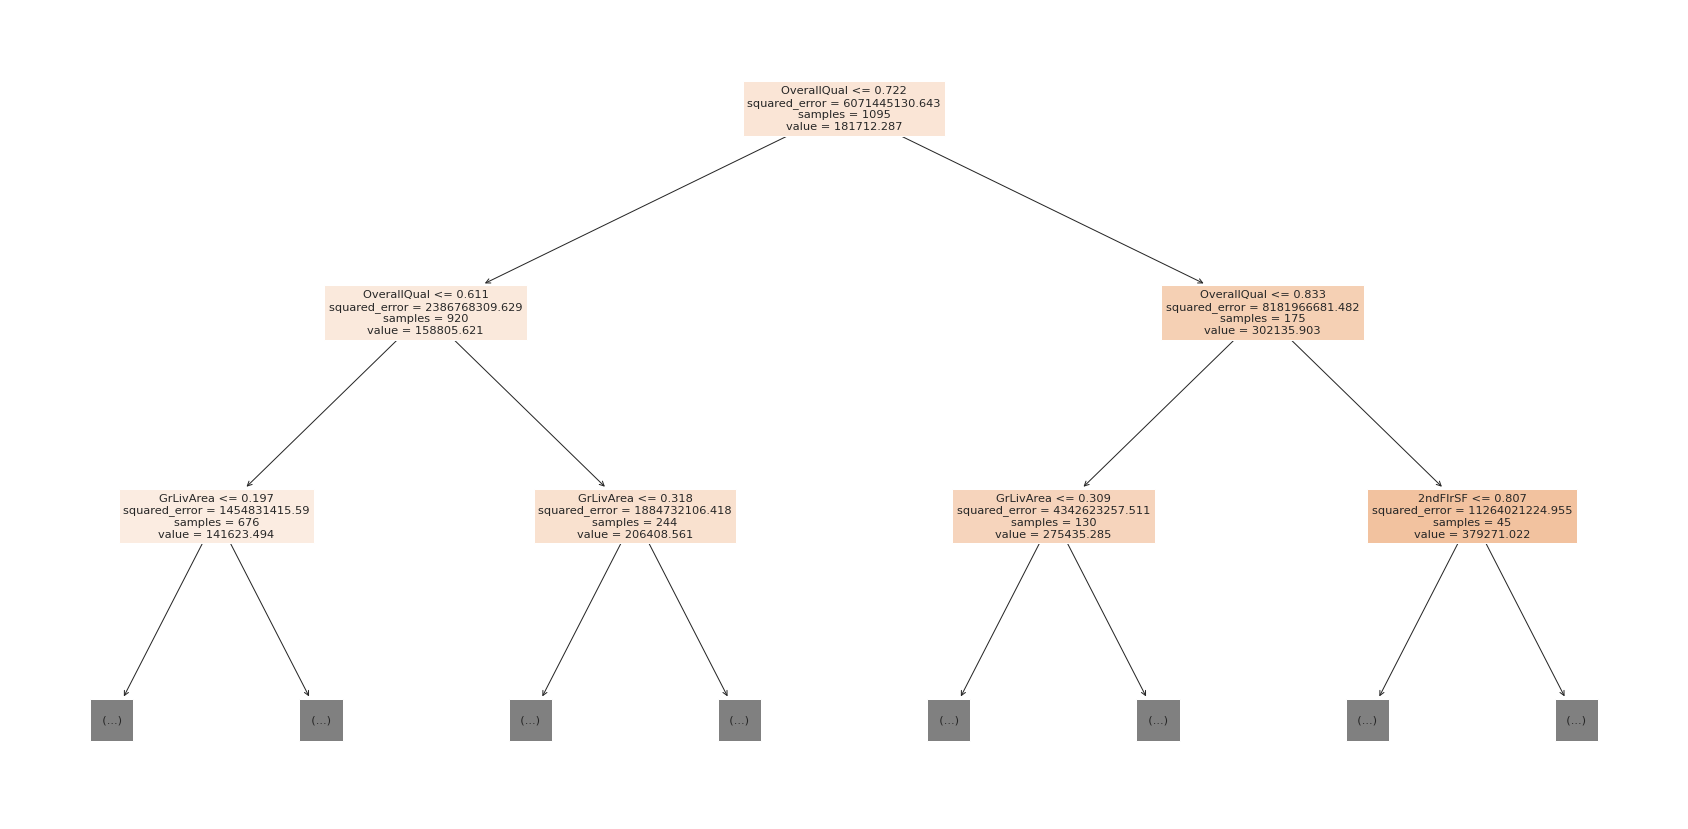

In [17]:
plt.figure(figsize=(30,15))

# Visualize the tree graphically using plot_tree
plot_tree(tree, feature_names= train_inputs.columns, max_depth=2, filled=True);

In [22]:
# Visualize the tree textually using export_text
tree_text = export_text(tree, max_depth=10, feature_names=list(train_inputs.columns))

In [23]:
# Display the first few lines
print(tree_text[:2000])

|--- OverallQual <= 0.72
|   |--- OverallQual <= 0.61
|   |   |--- GrLivArea <= 0.20
|   |   |   |--- TotalBsmtSF <= 0.16
|   |   |   |   |--- OverallQual <= 0.39
|   |   |   |   |   |--- GarageCond_TA <= 0.50
|   |   |   |   |   |   |--- LotArea <= 0.04
|   |   |   |   |   |   |   |--- CentralAir_Y <= 0.50
|   |   |   |   |   |   |   |   |--- YearBuilt <= 0.54
|   |   |   |   |   |   |   |   |   |--- SaleCondition_Abnorml <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Neighborhood_BrkSide <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Neighborhood_BrkSide >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [39300.00]
|   |   |   |   |   |   |   |   |   |--- SaleCondition_Abnorml >  0.50
|   |   |   |   |   |   |   |   |   |   |--- 2ndFlrSF <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- value: [34900.00]
|   |   |   |   |   |   |   |   |   |   |--- 2ndFlrSF >  0.09
|   |   |  

In [24]:
# Check feature importance
tree_importances = tree.feature_importances_

In [25]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [26]:
tree_importance_df

,feature,importance
3,OverallQual,0.632537
15,GrLivArea,0.104334
13,2ndFlrSF,0.031896
11,TotalBsmtSF,0.028504
12,1stFlrSF,0.026730
...,...,...
104,Condition2_RRAn,0.000000
103,Condition2_RRAe,0.000000
102,Condition2_PosN,0.000000
212,BsmtFinType2_nan,0.000000


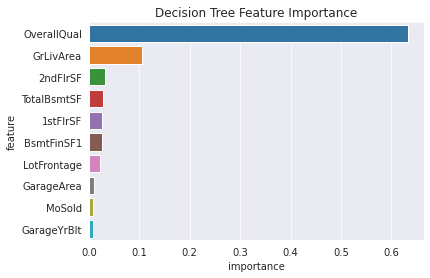

In [27]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

## Random Forests


> **QUESTION 4**: Train a random forest regressor using the training set.

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
# Create the model
rf1 = RandomForestRegressor(random_state=42, n_jobs=-1).fit(train_inputs, train_targets)

In [30]:
# Fit the model
rf1.fit(train_inputs, train_targets)

RandomForestRegressor(n_jobs=-1, random_state=42)

> **QUESTION 5**: Make predictions using the random forest regressor.

In [31]:
rf1_train_preds = rf1.predict(train_inputs)

In [32]:
rf1_train_rmse = mean_squared_error(rf1_train_preds, train_targets, squared=False)

In [33]:
rf1_val_preds = rf1.predict(val_inputs)

In [34]:
rf1_val_rmse = mean_squared_error(rf1_val_preds, val_targets, squared=False)

In [35]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 11864.318299877767, Validation RMSE: 27830.03863639856


## Hyperparameter Tuning

Let us now tune the hyperparameters of our model. You can find the hyperparameters for `RandomForestRegressor` here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Hyperparameters are use

Let's define a helper function `test_params` which can test the given value of one or more hyperparameters.

In [36]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

It can be used as follows:

In [37]:
test_params(n_estimators=20, max_depth=20)

(13776.89957127333, 28886.033523273858)

In [38]:
test_params(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)

(20490.359632429263, 29804.931642791602)

Let's also define a helper function to test and plot different values of a single parameter.

In [39]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

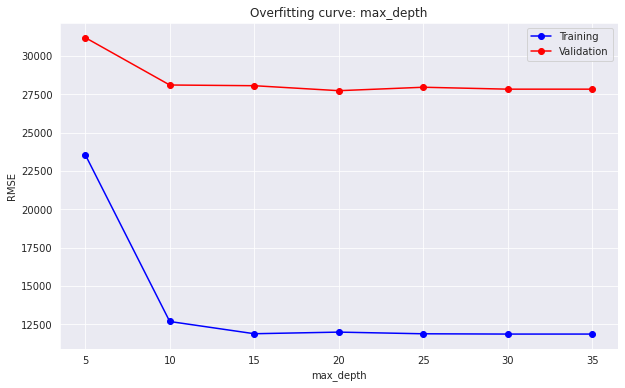

In [40]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

From the above graph, it appears that the best value for `max_depth` is around 20, beyond which the model starts to overfit.

> **QUESTION 6**: Use the `test_params` and `test_param_and_plot` functions to experiment with different values of the  hyperparmeters like `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, `min_impurity_decrease`, `min_impurity_split` etc. You can learn more about the hyperparameters here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [41]:
test_params(n_estimators=50, max_depth=10, min_samples_leaf=1, max_features=0.2)

(13815.915846207305, 27801.60795025301)

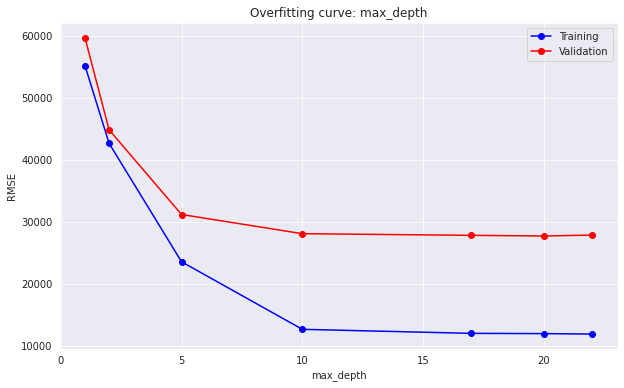

In [42]:
test_param_and_plot('max_depth', [1, 2, 5, 10, 17, 20, 22])

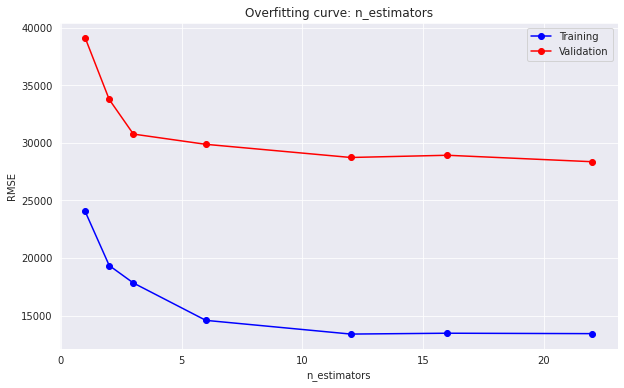

In [43]:
test_param_and_plot('n_estimators', [1, 2, 3, 6, 12, 16, 22])

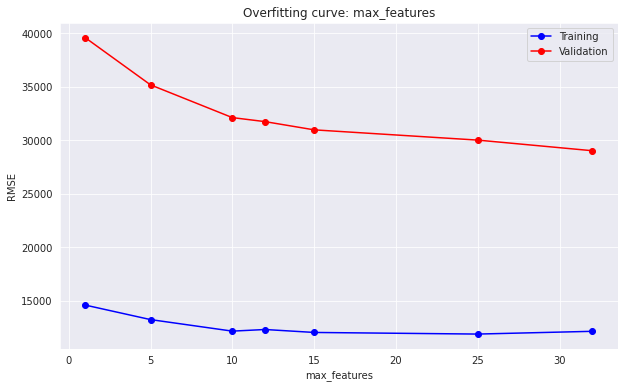

In [44]:
test_param_and_plot('max_features', [1, 5, 10, 12, 15, 25, 32])

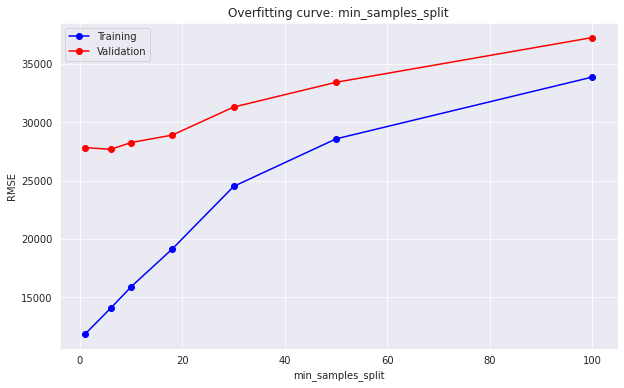

In [45]:
test_param_and_plot('min_samples_split', [1, 6, 10, 18, 30, 50, 100])

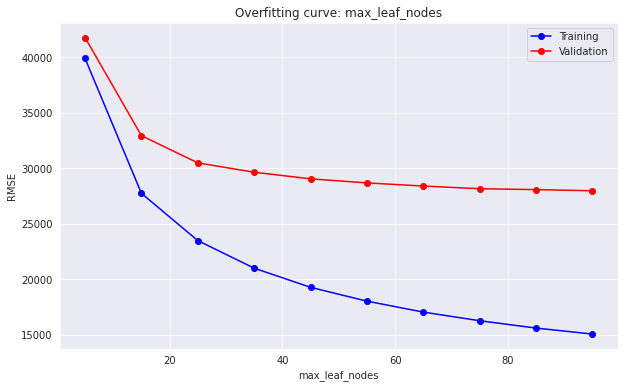

In [46]:
test_param_and_plot('max_leaf_nodes', range(5, 100, 10))

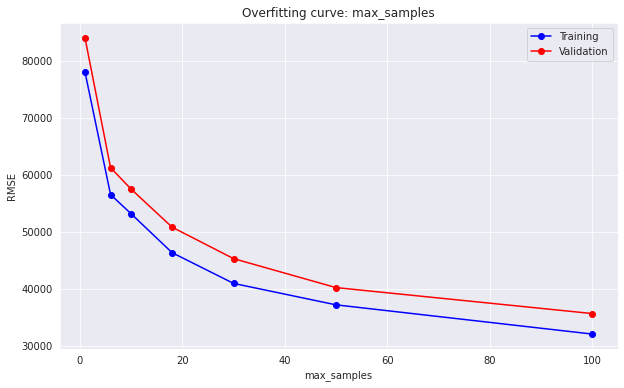

In [47]:
test_param_and_plot('max_samples', [1, 6, 10, 18, 30, 50, 100])

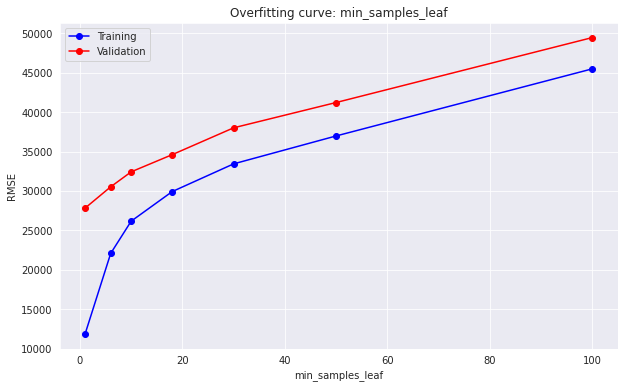

In [48]:
test_param_and_plot('min_samples_leaf', [1, 6, 10, 18, 30, 50, 100])

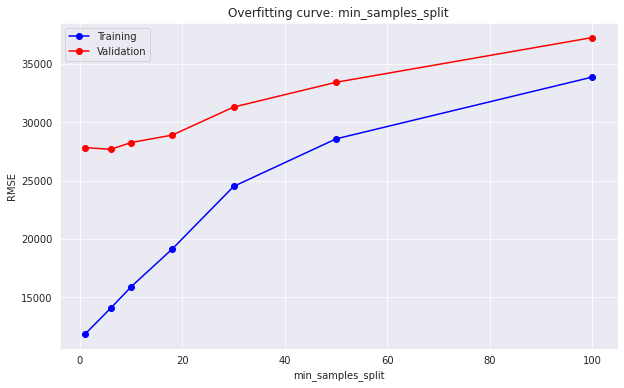

In [49]:
test_param_and_plot('min_samples_split', [1, 6, 10, 18, 30, 50, 100])

## Training the Best Model

> **QUESTION 7**: Train a random forest regressor model with your best hyperparameters to minimize the validation loss.

In [50]:
# Create the model with custom hyperparameters
best_hyperparams = {
    "n_estimators" : 12,
    "max_features" : 0.2,
    'max_samples' : 0.2,
    'min_samples_leaf' : 1
}
rf2 = RandomForestRegressor(**best_hyperparams)

In [51]:
# Train the model
rf2.fit(train_inputs, train_targets)

RandomForestRegressor(max_features=0.2, max_samples=0.2, n_estimators=12)

> **QUESTION 8**: Make predictions and evaluate your final model. If you're unhappy with the results, modify the hyperparameters above and try again.

In [52]:
rf2_train_preds = rf1.predict(train_inputs)

In [53]:
rf2_train_rmse = mean_squared_error(rf1_train_preds, train_targets, squared=False)

In [54]:
rf2_val_preds = rf1.predict(val_inputs)

In [55]:
rf2_val_rmse = mean_squared_error(rf1_val_preds, val_targets, squared=False)

In [56]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 11864.318299877767, Validation RMSE: 27830.03863639856


Let's also view and plot the feature importances.

In [57]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

In [58]:
rf2_importance_df

,feature,importance
3,OverallQual,0.143679
12,1stFlrSF,0.116978
15,GrLivArea,0.093439
8,BsmtFinSF1,0.078339
11,TotalBsmtSF,0.048247
...,...,...
132,RoofMatl_WdShngl,0.000000
134,Exterior1st_AsphShn,0.000000
135,Exterior1st_BrkComm,0.000000
137,Exterior1st_CBlock,0.000000


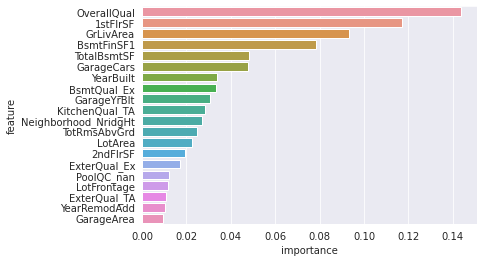

In [59]:
sns.barplot(data=rf2_importance_df[:20], x='importance', y='feature')

## Making Predictions on the Test Set

Let's make predictions on the test set provided with the data.

In [60]:
test_df = pd.read_csv('house-prices/test.csv')

In [61]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

First, we need to reapply all the preprocessing steps.

In [62]:
test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
test_df[encoded_cols] = encoder.transform(test_df[categorical_cols])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [63]:
test_inputs = test_df[numeric_cols + encoded_cols]

We can now make predictions using our final model.

In [64]:
test_preds = rf2.predict(test_inputs)

In [65]:
submission_df = pd.read_csv('house-prices/sample_submission.csv')

In [66]:
submission_df

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


Let's replace the values of the `SalePrice` column with our predictions.

In [67]:
submission_df['SalePrice'] = test_preds

Let's save it as a CSV file and download it.

In [68]:
submission_df.to_csv('submission.csv', index=False)

In [69]:
from IPython.display import FileLink
FileLink('submission.csv') # Doesn't work on Colab, use the file browser instead to download the file.

/content/submission.csv

We can now submit this file to the competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submissions

![](https://i.imgur.com/6h2vXRq.png)
